# Model Training Part
This notebook trains five classification models on classification datasets, evaluates them, and saves each trained model as a 
`.pkl` file. It also saves the feature list used for training so the Streamlit app can load and evaluate the models consistently.

**Models trained:** Logistic Regression, Decision Tree, Random Forest, Gaussian Naive Bayes, SVM.



In [1]:
# Part 1: Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder

print('Libraries loaded.')

Libraries loaded.


In [2]:
# Part 2: Utility functions (load & preprocess)
from pathlib import Path
def load_data(file_path):
    """Load CSV data into a DataFrame."""
    return pd.read_csv(file_path)

def preprocess_data(X):
    """Convert all non-numeric columns to numeric using Label Encoding."""
    X_processed = X.copy()
    le_map = {}  # store label encoders per column for later reuse if needed
    for col in X_processed.columns:
        if X_processed[col].dtype == 'object' or X_processed[col].dtype.name == 'category':
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X_processed[col].astype(str))
            le_map[col] = le
    return X_processed, le_map

In [3]:
# Part 3: Train models and save pickles
def train_models(X_train, y_train, save_pickles=True):
    """Train models and (optionally) save each model as a .pkl file."""
    X_train_proc, le_map = preprocess_data(X_train)
    
    # Encode target if it's categorical
    y_train_proc = y_train.copy()
    le_y = None
    if y_train_proc.dtype == 'object' or y_train_proc.dtype.name == 'category':
        le_y = LabelEncoder()
        y_train_proc = le_y.fit_transform(y_train_proc.astype(str))
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=200),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Naive Bayes': GaussianNB(),
        'SVM': SVC(probability=True, random_state=42)
    }
    fitted_models = {}
    for name, model in models.items():
        model.fit(X_train_proc, y_train_proc)
        fitted_models[name] = model
        if save_pickles:
            with open(f"{name}.pkl", 'wb') as f:
                pickle.dump(model, f)
    # Save metadata: feature names and label encoder for target if any
    metadata = {
        'features': list(X_train.columns),
        'le_map_columns': list(le_map.keys()),
        'le_y_classes': (le_y.classes_.tolist() if le_y is not None else None)
    }
    with open('model_metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    print('Trained and saved models and metadata.')
    return fitted_models, metadata

In [4]:
# Part 4: Evaluation function (returns DataFrame)
def evaluate_models(fitted_models, X_test, y_test):
    """Evaluate models with automatic categorical encoding (LabelEncoder) and return a DataFrame of metrics."""
    X_test_proc, _ = preprocess_data(X_test)
    
    y_test_proc = y_test.copy()
    if y_test_proc.dtype == 'object' or y_test_proc.dtype.name == 'category':
        le_y = LabelEncoder()
        y_test_proc = le_y.fit_transform(y_test_proc.astype(str))
    
    results = []
    for name, model in fitted_models.items():
        y_pred = model.predict(X_test_proc)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test_proc, y_pred),
            'Precision': precision_score(y_test_proc, y_pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_test_proc, y_pred, average='weighted', zero_division=0),
            'F1 Score': f1_score(y_test_proc, y_pred, average='weighted', zero_division=0)
        })
    return pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

In [5]:
# Part 5: Confusion matrix plotting
def plot_confusion_matrices(fitted_models, X_test, y_test):
    """Plot confusion matrices for each model with class labels preserved."""
    X_test_proc, _ = preprocess_data(X_test)
    
    # If target is categorical, encode it but store class labels
    if y_test.dtype == 'object' or y_test.dtype.name == 'category':
        le_y = LabelEncoder()
        y_test_encoded = le_y.fit_transform(y_test.astype(str))
        class_labels = le_y.classes_
    else:
        y_test_encoded = y_test.copy()
        class_labels = sorted(list(set(y_test_encoded)))
    
    fig, axes = plt.subplots(1, len(fitted_models), figsize=(5 * len(fitted_models), 4))
    if len(fitted_models) == 1:
        axes = [axes]
    
    for ax, (name, model) in zip(axes, fitted_models.items()):
        y_pred = model.predict(X_test_proc)
        cm = confusion_matrix(y_test_encoded, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=class_labels, yticklabels=class_labels)
        ax.set_title(name)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

Found dataset. Running example training...
Trained and saved models and metadata.

Model comparison:


,Model,Accuracy,Precision,Recall,F1 Score
2,Random Forest,0.861111,0.861308,0.861111,0.860969
0,Logistic Regression,0.850000,0.850611,0.850000,0.850069
4,SVM,0.850000,0.852894,0.850000,0.849285
3,Naive Bayes,0.827778,0.835972,0.827778,0.825913
1,Decision Tree,0.788889,0.789877,0.788889,0.788993



Confusion matrices:


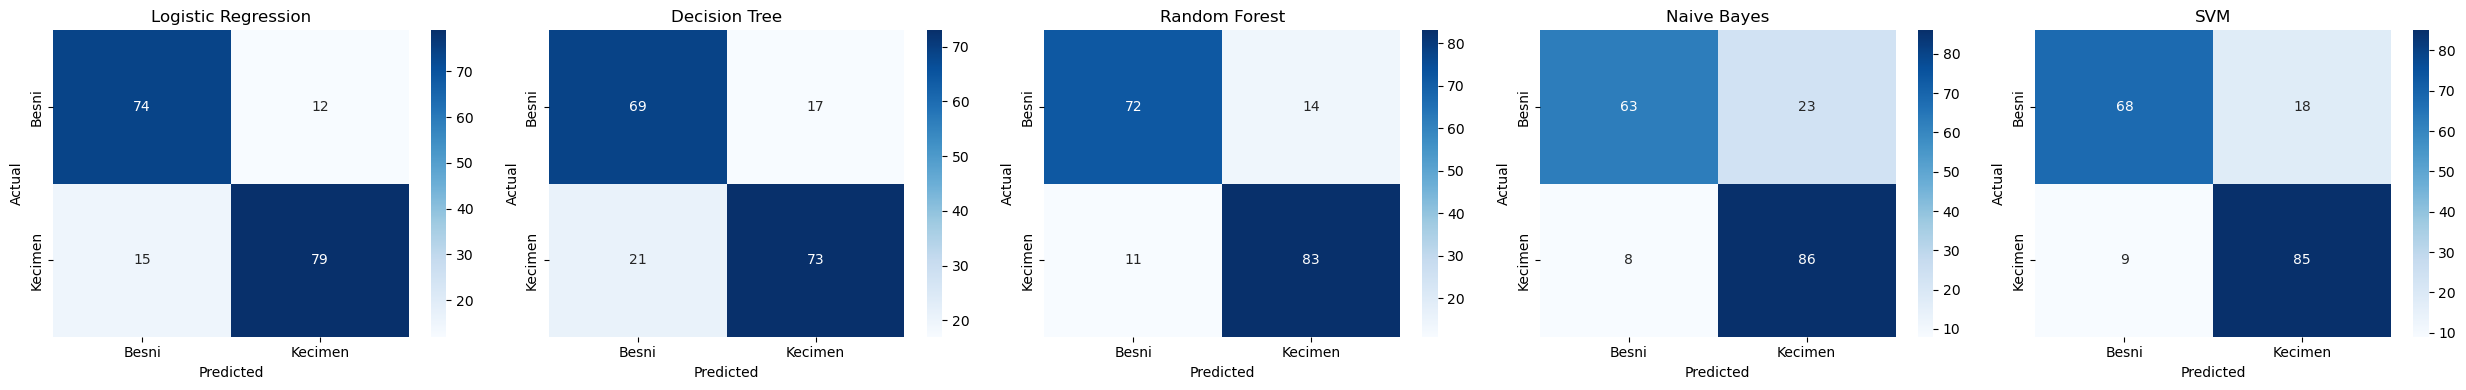

In [9]:
# Example run: train on PlayCricket.csv if available
dataset_path = 'Raisin_Dataset.csv'
if Path(dataset_path).exists():
    print('Found dataset. Running example training...')
    df = load_data(dataset_path)
    # assume last column is the target as in your example
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    fitted, metadata = train_models(X_train, y_train, save_pickles=True)
    print('\nModel comparison:')
    display(evaluate_models(fitted, X_test, y_test))
    print('\nConfusion matrices:')
    plot_confusion_matrices(fitted, X_test, y_test)
else:
    print('csv not found in the notebook folder. Place the CSV here and re-run this cell to train and save pickles.')